# COMP30027 Machine Learning Project 2

In [2]:
import numpy as np
import pandas as pd
import pickle
import scipy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
from datetime import datetime

# Read file 
def read_data(filename):
    
    return pd.read_csv(filename)


## Function to clean raw data from basic book_rating csv dataset

In [3]:
def clean_raw(dataframe, text_df):
    dataframe = pd.concat([dataframe,text_df], axis=1)
    
    # convert date format 
    dataframe.rename(columns={'PublishYear': 'year', 'PublishMonth': 'month', 'PublishDay': 'day'}, inplace=True)
    dataframe['CombinedDate'] = pd.to_datetime(dataframe[['year', 'month', 'day']], errors='coerce')
    
    
    # Determine the range of your datetime values
    min_date = dataframe['CombinedDate'].min()
        
    # Converting datetime64 into numerical representation
    dataframe['CombinedDate'] = (dataframe['CombinedDate'] - pd.Timestamp(min_date)) // pd.Timedelta('1D')
    
    # drop irrelavant columns
    cleaned_df = dataframe.drop(columns=['year','month','day'])
    
    # Drop Language feature
    cleaned_df = cleaned_df.drop(columns=['Language'])
    
    # Drop Publisher
    cleaned_df = cleaned_df.drop(columns=['Publisher', 'Name', 'Authors', 'Description','pagesNumber'])
    
    
    #Impute missing values
    impute = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputed_data = impute.fit_transform(cleaned_df)

    # Convert the imputed_data back to a DataFrame
    cleaned_df = pd.DataFrame(imputed_data, columns=cleaned_df.columns)
    
    return cleaned_df

## Combining all relevant dataset and perform preprocessing

In [5]:
training_data = read_data("D:\\University\\University of Melbourne\\Machine Learning\\Assignment 2\\project_data_files\\book_rating_train.csv")
vocab = pickle.load(open("D:\\University\\University of Melbourne\\Machine Learning\\Assignment 2\\project_data_files\\book_text_features_countvec\\book_text_features_countvec\\train_name_countvectorizer.pkl", "rb"))
vocab_dict = vocab.vocabulary_

sp_name = scipy.sparse.load_npz("D:\\University\\University of Melbourne\\Machine Learning\\Assignment 2\\project_data_files\\book_text_features_countvec\\book_text_features_countvec\\train_name_vec.npz")
sp_author = scipy.sparse.load_npz("D:\\University\\University of Melbourne\\Machine Learning\\Assignment 2\\project_data_files\\book_text_features_countvec\\book_text_features_countvec\\train_authors_vec.npz")
sp_description = scipy.sparse.load_npz("D:\\University\\University of Melbourne\\Machine Learning\\Assignment 2\\project_data_files\\book_text_features_countvec\\book_text_features_countvec\\train_desc_vec.npz")

test_data = read_data("D:\\University\\University of Melbourne\\Machine Learning\\Assignment 2\\project_data_files\\book_rating_test.csv")
sp_test_name = scipy.sparse.load_npz("D:\\University\\University of Melbourne\\Machine Learning\\Assignment 2\\project_data_files\\book_text_features_countvec\\book_text_features_countvec\\test_name_vec.npz")
sp_test_author = scipy.sparse.load_npz("D:\\University\\University of Melbourne\\Machine Learning\\Assignment 2\\project_data_files\\book_text_features_countvec\\book_text_features_countvec\\test_authors_vec.npz")
sp_test_description = scipy.sparse.load_npz("D:\\University\\University of Melbourne\\Machine Learning\\Assignment 2\\project_data_files\\book_text_features_countvec\\book_text_features_countvec\\test_desc_vec.npz")

# Transforming CountVectoriser training data sparse matrix with Tfidf
fooTfmer = TfidfTransformer()
docs_tfidf_name = fooTfmer.fit_transform(sp_name)
docs_tfidf_authors = fooTfmer.fit_transform(sp_author)
docs_tfidf_description = fooTfmer.fit_transform(sp_description)
# Transforming CountVectoriser test data sparse matrix with Tfidf
test_tfidf_name = fooTfmer.fit_transform(sp_test_name)
test_tfidf_authors = fooTfmer.fit_transform(sp_test_author)
test_tfidf_description = fooTfmer.fit_transform(sp_test_description)

# perform truncated SVD
svd = TruncatedSVD(n_components=10)
reduced_tfidf_matrix_name = svd.fit_transform(docs_tfidf_name)
reduced_tfidf_matrix_authors = svd.fit_transform(docs_tfidf_authors)
reduced_tfidf_matrix_description = svd.fit_transform(docs_tfidf_description)

#perform truncated SVD for test data
reduced_tfidf_test_name = svd.fit_transform(test_tfidf_name)
reduced_tfidf_test_authors = svd.fit_transform(test_tfidf_authors)
reduced_tfidf_test_description = svd.fit_transform(test_tfidf_description)

# Set tfidf column name 
tfidf_name_col = ['name1', 'name2','name3','name4','name5','name6','name7','name8','name9','name10']
tfidf_author_col = ['author1', 'author2','author3','author4','author5','author6','author7','author8','author9','author10']
tfidf_desc_col = ['desc1', 'desc2','desc3','desc4','desc5','desc6','desc7','desc8','desc9','desc10']
name_df = pd.DataFrame(reduced_tfidf_matrix_name[1:], columns = tfidf_name_col)
author_df = pd.DataFrame(reduced_tfidf_matrix_authors[1:], columns = tfidf_author_col)
desc_df = pd.DataFrame(reduced_tfidf_matrix_description[1:], columns = tfidf_desc_col)
# Converting Test df tfidf into dataframe 
test_name = pd.DataFrame(reduced_tfidf_test_name[1:], columns = tfidf_name_col)
test_author = pd.DataFrame(reduced_tfidf_test_authors[1:], columns = tfidf_author_col)
test_desc = pd.DataFrame(reduced_tfidf_test_description[1:], columns = tfidf_desc_col)

# Concantenate 3 text based df
conc_df = pd.concat([name_df, author_df, desc_df], axis=1)
conc_test_df = pd.concat([test_name, test_author, test_desc], axis=1)

# Clean training dataset
nice_df = clean_raw(training_data,conc_df)
# Clean test dataset
test_nice = clean_raw(test_data,conc_test_df)

## Outlier detection

In [23]:
from sklearn.ensemble import IsolationForest
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
clf = IsolationForest(contamination=0.01)
clf.fit(nice_df)
outlier_labels = clf.predict(nice_df)

# Count the number of outliers
outlier = 0
total = 0
for i in range(len(outlier_labels)):
    total += 1
    if (outlier_labels[i] == -1):
        outlier += 1
print(outlier)

D:\Anaconda_Program\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


231


## Confusion matrix plot function

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix, class_labels, classifier_name):
    df_cm = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.title(classifier_name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## ZeroR baseline model

D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


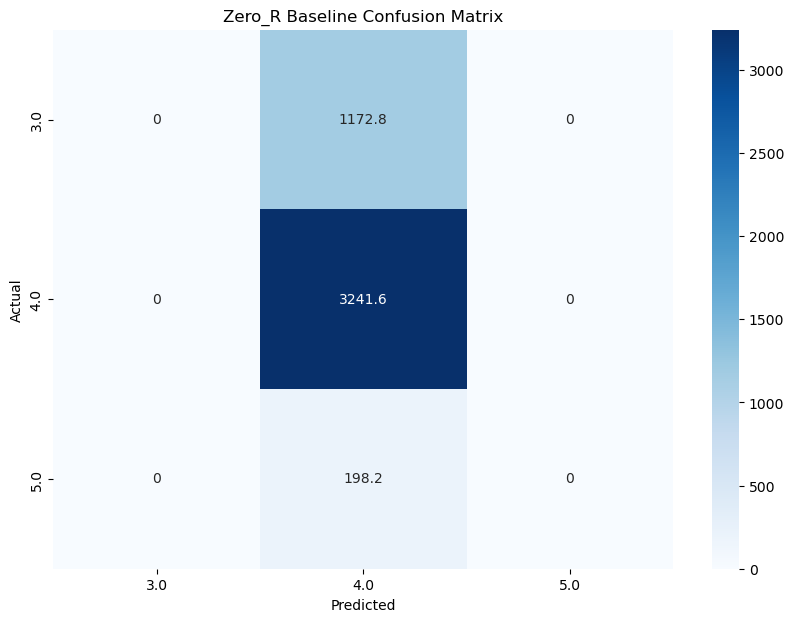

Classification report:
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00      5864
         4.0       0.70      1.00      0.83     16208
         5.0       0.00      0.00      0.00       991

    accuracy                           0.70     23063
   macro avg       0.23      0.33      0.28     23063
weighted avg       0.49      0.70      0.58     23063



D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score


# K-fold cross validation
X = nice_df.loc[:,nice_df.columns != 'rating_label']
y = nice_df['rating_label']

zeroR = DummyClassifier(strategy='most_frequent')

confusion_matrices = []
accuracies = []
y_true_all = []
y_pred_all = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    zeroR.fit(X_train, y_train)
    

    y_pred = zeroR.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Accumulate true and predicted labels for classification report
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    
# Calculate average accuracy and confusion matrix
average_accuracy = np.mean(accuracies)
average_cm = np.mean(confusion_matrices, axis=0)
report = classification_report(y_test, y_pred)
class_labels = np.unique(y)
classifier_name = "Zero_R Baseline Confusion Matrix"
plot_confusion_matrix(average_cm, class_labels, classifier_name)

# Calculate the classification report
report = classification_report(y_true_all, y_pred_all)
print("Classification report:\n", report)

# Predicting testfile class label
y_new = zeroR.predict(test_nice)
predicted_label = pd.DataFrame(y_new, columns = ['rating_label'])

predicted_label['id'] = predicted_label.index+1
columns_titles = ["id", "rating_label"]
predicted_label = predicted_label.reindex(columns=columns_titles)
predicted_label.to_csv("Zero R prediction.csv",index=False)
    

### Training and testing a Naive Bayes classifier

D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


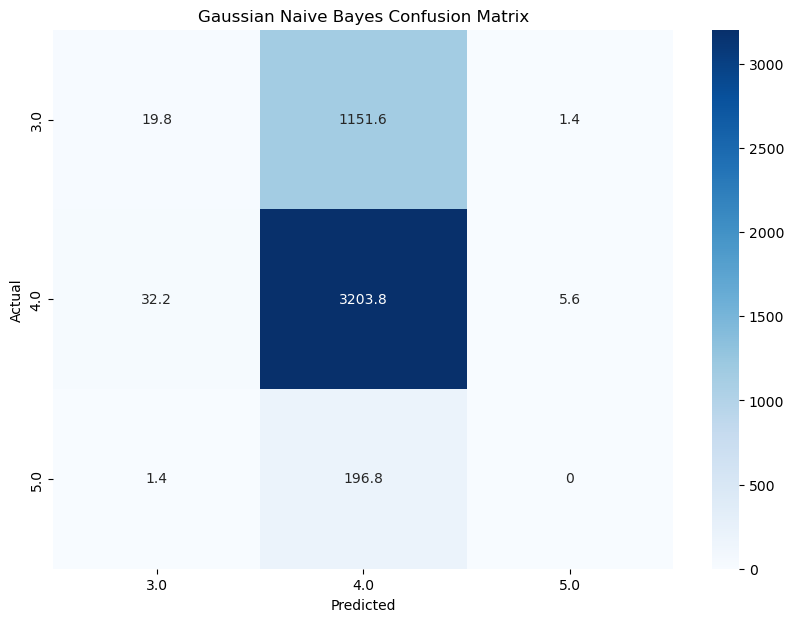

Classification report:
               precision    recall  f1-score   support

         3.0       0.37      0.02      0.03      5864
         4.0       0.70      0.99      0.82     16208
         5.0       0.00      0.00      0.00       991

    accuracy                           0.70     23063
   macro avg       0.36      0.34      0.28     23063
weighted avg       0.59      0.70      0.59     23063



In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import scipy.stats as stats

# Initialize StratifiedKFold with a specific number of splits (e.g., 5)
skf = StratifiedKFold(n_splits=5)

confusion_matrices = []
accuracies = []
y_true_all = []
y_pred_all = []

X = nice_df.loc[:,nice_df.columns != 'rating_label']
y = nice_df['rating_label']


# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    
    # Train the classifier on the training set
    gnb = GaussianNB()
    selector = SelectKBest(f_classif, k=20) 
    
    # Create a pipeline with the feature selection and classifier
    pipeline = Pipeline([('selector', selector), ('gnb', gnb)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Accumulate true and predicted labels for classification report
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)



# Calculate average accuracy and confusion matrix
average_accuracy = np.mean(accuracies)
average_cm = np.mean(confusion_matrices, axis=0)
report = classification_report(y_test, y_pred)
class_labels = np.unique(y)
classifier_name = "Gaussian Naive Bayes Confusion Matrix"
plot_confusion_matrix(average_cm, class_labels, classifier_name)

# Calculate the classification report
report = classification_report(y_true_all, y_pred_all)
print("Classification report:\n", report)

# Predicting testfile class label
y_new = pipeline.predict(test_nice)
predicted_label = pd.DataFrame(y_new, columns = ['rating_label'])

predicted_label['id'] = predicted_label.index+1
columns_titles = ["id", "rating_label"]
predicted_label = predicted_label.reindex(columns=columns_titles)
predicted_label.to_csv("Naive Bayes prediction.csv",index=False)



## Draw Naive bayes learning curves

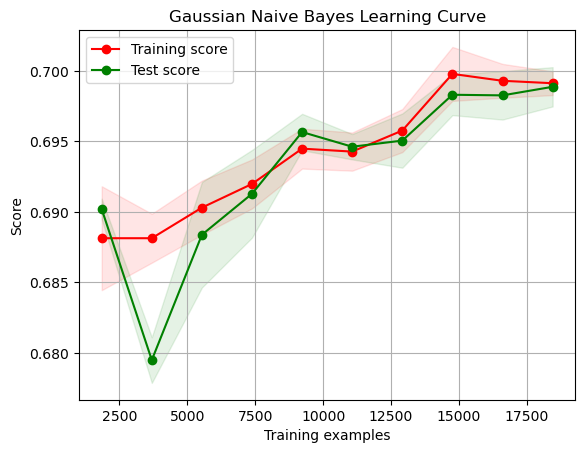

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Calculate the learning curve 
X = nice_df.loc[:,nice_df.columns != 'rating_label']
y = nice_df['rating_label']
train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, cv=skf, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Gaussian Naive Bayes Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

plt.legend(loc="best")
plt.show()

## Training and testing KNN

D:\Anaconda_Program\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda_Program\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True

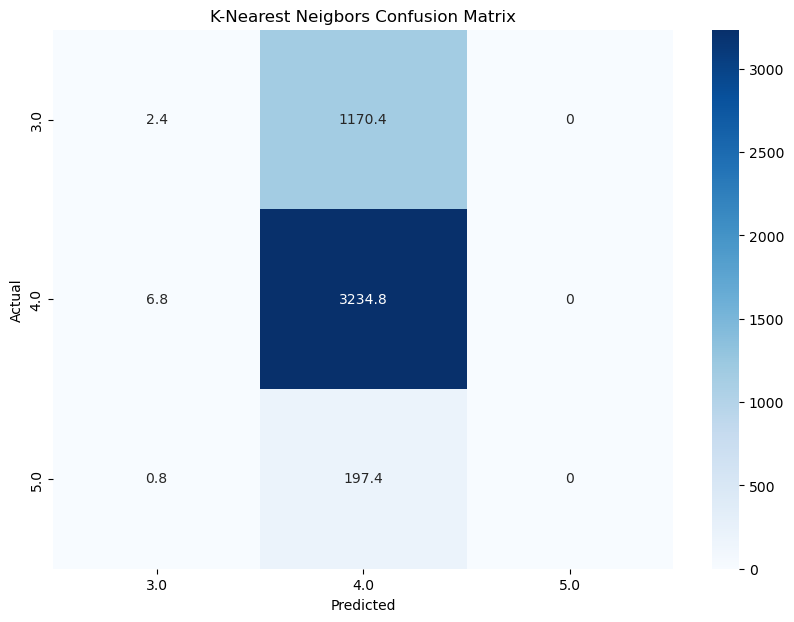

Classification report:
               precision    recall  f1-score   support

         3.0       0.24      0.00      0.00      5864
         4.0       0.70      1.00      0.82     16208
         5.0       0.00      0.00      0.00       991

    accuracy                           0.70     23063
   macro avg       0.31      0.33      0.28     23063
weighted avg       0.55      0.70      0.58     23063



D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda_Program\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif,  f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

confusion_matrices = []
accuracies = []

X = nice_df.loc[:,nice_df.columns != 'rating_label']
y = nice_df['rating_label']

y_true_all = []
y_pred_all = []


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create and train the KNN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=50, metric='euclidean')
    selector = SelectKBest(f_classif, k=5) 
    pipeline_knn = Pipeline([('selector', selector), ('knn_classifier', knn_classifier)])
    pipeline_knn.fit(X_train, y_train)

    # Predict the target values for the test set
    y_pred = pipeline_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Accumulate true and predicted labels for classification report
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)


average_accuracy = np.mean(accuracies)
average_cm = np.mean(confusion_matrices, axis=0)



class_labels = np.unique(y)
classifier_name = "K-Nearest Neigbors Confusion Matrix"
plot_confusion_matrix(average_cm, class_labels, classifier_name)

# Calculate the classification report
report = classification_report(y_true_all, y_pred_all)
print("Classification report:\n", report)

# Predicting testfile class label
y_new = pipeline.predict(test_nice)
predicted_label = pd.DataFrame(y_new, columns = ['rating_label'])

predicted_label['id'] = predicted_label.index+1
columns_titles = ["id", "rating_label"]
predicted_label = predicted_label.reindex(columns=columns_titles)
predicted_label.to_csv("KNN prediction.csv",index=False)

## Draw KNN learning curves

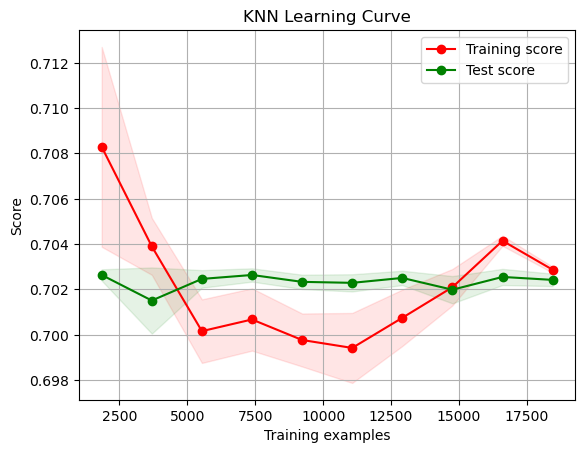

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Calculate the learning curve 
X = nice_df.loc[:,nice_df.columns != 'rating_label']
y = nice_df['rating_label']
train_sizes, train_scores, test_scores = learning_curve(pipeline_knn, X, y, cv=skf, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("KNN Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

plt.legend(loc="best")
plt.show()